# Hand Pose Estimation
This project will estimate the joint position on the hand images from [NYU NYU Hand Pose Dataset](http://cims.nyu.edu/~tompson/NYU_Hand_Pose_Dataset.htm). This project will preprocess the images, then train a convolutional neural network on all the samples. The input need to contain the PCA imformation. The image needs many preprocessing. The labels need to be reduced to 2D.

## Data Exploration
### Images
* The NYU Hand pose dataset contains 8252 test-set and 72757 training-set frames
* Each image is 640x480x3 unsigned char bit.
* Images contain either RGB, depth, or synthetic depth data, from a front, top, or side camera.
* Images are named as type_k_f.png'. For example depth_1_1.png is depth frame 1 for No.1 camera.
* The indices start at 1.

* * *
####  Import libs for preprocess data

In [1]:
# Data import
import h5py
import numpy as np
import pandas as pd
import scipy.io as sio
from keras.utils.generic_utils import Progbar
from PIL import Image
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
from os import path
from itertools import chain
import random
from random import randint
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
# Model import
from keras.models import Sequential, model_from_yaml, load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import math
# Load model
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


* * * 
#### The utilities about data path

In [4]:
# The data size.
MAX_NUM_TRAIN = 72757
MAX_NUM_TEST  = 8252
# That's a huge data therefore I used absolute path.
INPUT_DIR     = 'D:\\nyu_hand_dataset_v2\\dataset'
# A lambda to join subfolder
data_path     = lambda *args : path.join(INPUT_DIR, *args)
# A lambda to generate file name
image_path    = lambda type, angle, index : '%s_%d_%07d.png' % (type, angle, index + 1)
# The file name of the labels data
labels_path   = 'joint_data.mat'
# In each depth png file the top 8 bits of depth are packed into the green channel and the lower 8 bits into blue.
converted_depth = lambda image: np.expand_dims((image[:, :, 1] << 8) + image[:, :, 2], 2)

# load a single image and labels
def load_data(set, type, angle,data_length, dtype='uint16'):
    labels = load_labels(set, angle)
    image_paths = (data_path(set, image_path(type, angle, i)) for i in range(data_length))
    images = load_images(image_paths, dtype)
    return images, labels
# load specified image 
def load_images(image_paths, dtype='uint16'):
    for image_path in image_paths:
        with Image.open(image_path) as image:
            yield np.asarray(image, dtype)

* * * 
#### Exploratory Visualization

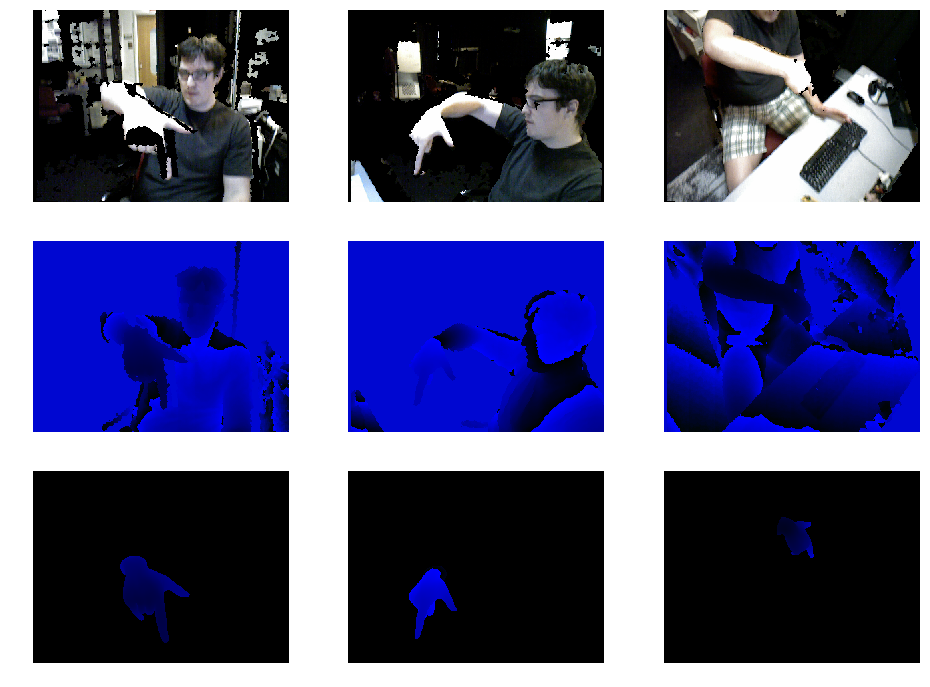

In [22]:
# Load demo images
demo_frame = randint(1,MAX_NUM_TRAIN)
demo_images = load_images([data_path('train', image_path(type, angle, demo_frame)) \
                           for type in ['rgb', 'depth', 'synthdepth'] \
                           for angle in range(1, 4)], 'uint8')
# Show demo images by 3x3 grids.
plt.figure(figsize=(16, 12))
for i, demo_image in enumerate(demo_images):
    plt.subplot(331 + i)
    
    ax = plt.gca()
    ax.set_axis_off()
    ax.set_xlim([0, demo_image.shape[1]])
    ax.set_ylim([demo_image.shape[0], 0])
    
    plt.imshow(demo_image)

* * *
### Labels
The labels are stored in the MATLAB .mat format as double precision floating point numbers
* joint_names - Cell of strings containing the names of the 36 key hand locations
* joint_uvd - The depth image space location of each joint in the training-set frames
  * u: The coordinate of pixel space.
  * v: The coordinate of pixel space.
  * d: The distance between projected plane to the vetex.
* joint_xyz - The world location of each joint in the training-set frames
* * *
#### Load labels function


In [6]:
# Load all lebels from a camera.
def load_labels(set, camera):
    joint_data  = sio.loadmat(data_path(set, labels_path))
    labels      = joint_data['joint_uvd'][camera - 1]
    joint_names = [name[0] for name in joint_data['joint_names'][0]]
    item_index = np.arange(labels.shape[0])
    labels_index = pd.MultiIndex.from_product([item_index, joint_names],names=['frame', 'joint_name'])
    return pd.DataFrame(labels.reshape(len(labels_index),3), index = labels_index, columns=['u','v','d'])

[]

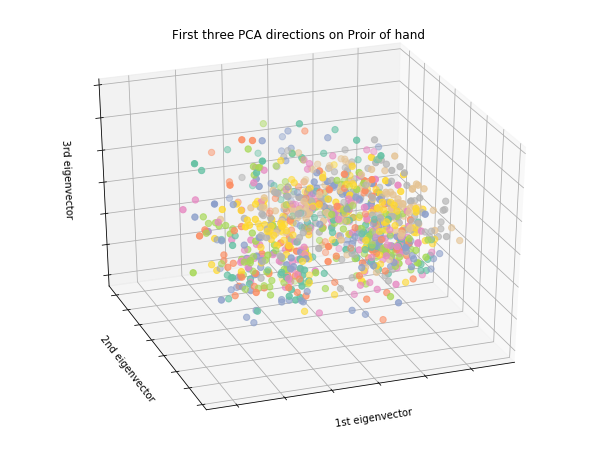

In [27]:
loaded_labels = load_labels('test', 1)
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(loaded_labels)
idx = np.random.randint(X_reduced.shape[0], size=1000)
ax.scatter(X_reduced[idx, 0], X_reduced[idx, 1], X_reduced[idx, 2],c=idx%36,
           cmap=plt.cm.Set2, s=40)

ax.set_title("First three PCA directions on Proir of hand")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

* * *
#### Try to load a label and draw it on correspond image.

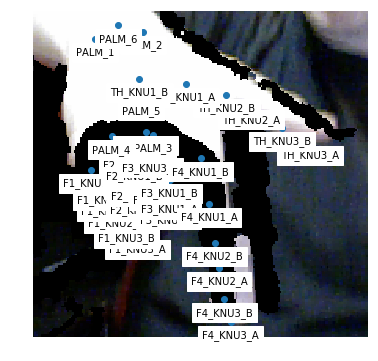

In [23]:
demo_image = load_images([data_path('train', image_path('rgb', 1, demo_frame))], 'uint8').__next__()
loaded_labels = load_labels('train', 1)
# Sliced a frame
demo_label = loaded_labels.loc[demo_frame]
plt.figure(figsize=(6, 6))
plt.gca().invert_yaxis()
plt.axis('equal')
plt.scatter(demo_label['u'], demo_label['v'])
plt.gca().set_autoscale_on(False)
plt.gca().set_axis_off()
plt.imshow(demo_image.squeeze())

for joint_name, joint_data in zip(demo_label.axes[0].values, demo_label[['u', 'v']].values):
    plt.annotate(joint_name,\
                 joint_data,\
                 xytext=(0, -8),\
                 textcoords='offset points',\
                 size=10,\
                 backgroundcolor='white',\
                 ha='center',\
                 va='top')

### Output
The dataset will be an hdf5 file.
This file contains the following groups:
* image
  * train
  * test
* label
  * train
  * test
* pca
  * eigenvectors
  * mean

#### Labels
Each label is  28×128×1 , containing the  uu  and  vv  values from the following hand keypoints, stored as single precision floating point numbers:

In [3]:
DATASET_DIR = 'dataset'
dataset     = h5py.File(path.join(DATASET_DIR, 'dataset.hdf5'))

#### Images
Each image is  128×128×1, containing depth data from the front angle, stored as single precision floating point numbers.
##### Get bounding box
Estimated a coarese 3D bounding box containning the hand by assuming label.

In [28]:
# Get a bounding box of the specified dimensions in centimeters around
# a point in uvd space
FX =  525 # NYU/Kinect
METRIC_SIZE = 38 #
METRIC_SIZE_FACTOR = FX*METRIC_SIZE
def bounding_box(center):
    bounding_box = np.array([[0, 0], [1, 1]], dtype='float')
    bounding_box -= 0.5
    bounding_box *= METRIC_SIZE
    bounding_box *= FX / center[-1]
    bounding_box += center[:-1]
    
    return bounding_box

#### Extract from the depth map
if the bounding box is out of image, the function will pad the image by edge

In [27]:
# ([[x_1, y_1], [x_2, y_2]])
# (x_1, y_1) :Minimum corner of the box
# (x_2, y_2) :Maximum corner of the box
def clip(image, bounding_box):
    image_box = np.array([[0,0],[640,480]])
    padding = np.array([image_box[0] - bounding_box[0], bounding_box[1] - image_box[1]]).clip(0)
    bounding_box += padding[0]
    padding = np.concatenate((padding[::-1], np.array([[0, 0]])))
    image = np.pad(image, padding, 'edge')
    image = image[bounding_box[0,1]:bounding_box[1,1],bounding_box[0,0]:bounding_box[1,0]]
    return image

##### Normalize
In addition to extracting image, the image should be resize to 128x128 and normalized to [-1,1]

In [26]:
def normalize(image, label):
    label = label.copy()

    label.loc.__setitem__((slice(None),'d'), (label['d'] / 10.)) # from millimeters to centimeters
    center = label.loc['F3_KNU1_B'].copy()
    image = image / 10. # from millimeters to centimeters
    center['d'] = label['d'].median()
    # Calulate bounding box
    bounds = bounding_box(center.values).astype(int)
    # Clip
    label.loc.__setitem__((slice(None),['u', 'v']),(label[['u','v']] - bounds[0]).values)
    image = clip(image, bounds)
    # normalize: Minus median to avoid Skewness
    label.loc.__setitem__((slice(None),'d'), (label['d'] - center['d']).values)
    image -= center['d']
    # Clamp
    image = np.clip(image, -15, 15) / 15.0
    label.loc.__setitem__((slice(None),'d'), label['d'].values /15.0)
    # Resize
    label.loc.__setitem__((slice(None),['u', 'v']),(label[['u','v']]*(np.array((128,128)) / image.shape[:-1])))               
    image = resize(np.squeeze(image),(128,128),mode='reflect')
    
    image = np.expand_dims(image, 2)
    cond = label.index.get_level_values('joint_name').isin(['F1_KNU3_A'])|\
    label.index.get_level_values('joint_name').isin(['F1_KNU2_B'])|\
    label.index.get_level_values('joint_name').isin(['F2_KNU3_A'])|\
    label.index.get_level_values('joint_name').isin(['F2_KNU2_B'])|\
    label.index.get_level_values('joint_name').isin(['F3_KNU3_A'])|\
    label.index.get_level_values('joint_name').isin(['F3_KNU2_B'])|\
    label.index.get_level_values('joint_name').isin(['F4_KNU3_A'])|\
    label.index.get_level_values('joint_name').isin(['F4_KNU2_B'])|\
    label.index.get_level_values('joint_name').isin(['TH_KNU3_A'])|\
    label.index.get_level_values('joint_name').isin(['TH_KNU3_B'])|\
    label.index.get_level_values('joint_name').isin(['TH_KNU2_B'])|\
    label.index.get_level_values('joint_name').isin(['PALM_1'])|\
    label.index.get_level_values('joint_name').isin(['PALM_2'])|\
    label.index.get_level_values('joint_name').isin(['PALM_3'])
    
    label = label.loc[cond].values.flatten()
    
    
    return image, label, center

#### Test the normalization 
Before entire processing, testing the function is necessary

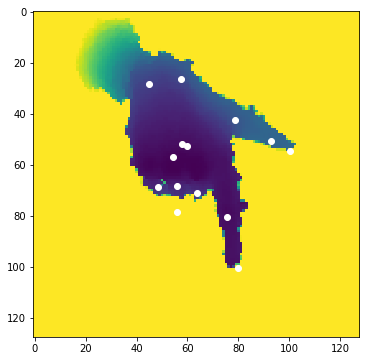

In [31]:
loaded_labels = load_labels('train', 1)
image = load_images([data_path('train', image_path('depth', 1, demo_frame))], 'uint8').__next__()

image = image.astype(int)
image = converted_depth(image)

label = loaded_labels.loc[demo_frame]
test_image, test_label,test_center = normalize(image,label)
plt.figure(figsize=(6, 6))
plt.imshow(test_image.squeeze())
plt.plot(test_label[::3], test_label[1::3], 'wo')

#### Process entire data

In [11]:
def process(set,data_length):
    data_image  = dataset.require_dataset('image/' + set, (data_length*3, 128, 128, 1), dtype='float')
    data_label  = dataset.require_dataset('label/' + set, (data_length*3, 42), dtype='float')
    data_center = dataset.require_dataset('center/' + set, (data_length*3, 3), dtype='float')
    p = Progbar(data_length*3)
    for i in range(0,3):
        images, labels = load_data(set,'depth',i+1,data_length)
        for image, item in zip(images, labels.groupby(level='frame')):
            index, label = item
            image = image.astype(int)
            image = converted_depth(image)
            
            data_image[(index*3)+i], data_label[(index*3)+i], data_center[(index*3)+i] =\
            normalize(image, label.loc[index])
            p.update((index*3)+i)     

#### Generate PCA
[Hands Deep in Deep Learning for Hand Pose Estimation](https://arxiv.org/abs/1502.06807) invents a prior model that uses PCA vector.

In [12]:
def pca(set, scale_range=np.zeros(3), translate_range=np.zeros(3)):
    data_label = np.repeat(dataset['label/' + set], 8, axis=0)
    
    scale = 1 + (np.random.random((len(data_label), 3)) - 0.5) * scale_range
    translate = (np.random.random((len(data_label), 3)) - 0.5) * translate_range
    
    scale = np.tile(scale, 14)
    translate = np.tile(translate, 14)
    
    data_label -= 64
    data_label *= scale
    data_label += 64
    data_label += translate
    
    data_pca_eigenvectors = dataset.require_dataset('pca/eigenvectors', (42, 42), dtype='float')
    data_pca_eigenvalues  = dataset.require_dataset('pca/eigenvalues', (42,), dtype='float')
    data_pca_mean         = dataset.require_dataset('pca/mean', (42,), dtype='float')

    pca = PCA().fit(data_label)

    data_pca_eigenvectors[:] = pca.components_
    data_pca_eigenvalues[:]  = pca.explained_variance_
    data_pca_mean[:]         = pca.mean_

#### Generate entrie data

In [10]:
process('train',data_length = MAX_NUM_TRAIN )

218264/218271 [============================>.] - ETA: 0s

In [98]:
process('test',data_length = MAX_NUM_TEST)

24755/24756 [============================>.] - ETA: 0s

In [70]:
pca('train', (0, 0, 0), (0, 0, 0))

#### Check the data is correct

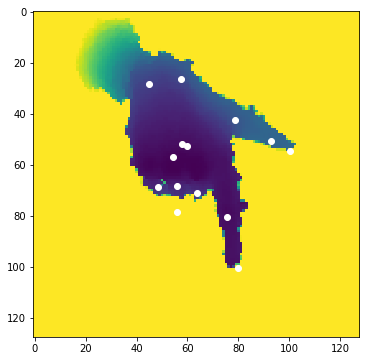

In [35]:
demo_image = dataset['image/train'][demo_frame*3]
demo_label = dataset['label/train'][demo_frame*3]

plt.figure(figsize=(6, 6))
plt.imshow(demo_image.squeeze())
plt.plot(demo_label[::3], demo_label[1::3], 'wo')

## Training
### Loading dataset

In [30]:
DATASET_DIR      = 'dataset'
dataset          = h5py.File(path.join(DATASET_DIR, 'dataset.hdf5'))



train_images     = dataset['image/train']
train_labels     = dataset['label/train']
train_centers    = dataset['center/train']

test_images      = dataset['image/test']
test_labels      = dataset['label/test']
test_centers     = dataset['center/test']

pca_eigenvectors = dataset['pca/eigenvectors'][:30]
pca_mean         = dataset['pca/mean']

### Generate batchs

In [31]:
def generate_batches(images, labels, batch_size):
    while True:
        batch_indices = [(i, min(i + batch_size, len(labels))) for i in range(0, len(labels), batch_size)]
        random.shuffle(batch_indices)
        for start, end in batch_indices:
            image_batch, label_batch = images[start:end], labels[start:end]
            yield image_batch, label_batch

### Setting keras

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

### Network layers
This network is very similar to [Hands Deep in Deep Learning for Hand Pose Estimation](https://arxiv.org/abs/1502.06807).

In [13]:
default_model = Sequential([\
                            Conv2D(\
                                   filters     = 8,\
                                   kernel_size = (5, 5),\
                                   strides     = (1, 1),\
                                   input_shape = (128, 128, 1)\
                                  ),\
                            MaxPooling2D(\
                                         pool_size = (3, 3)\
                                        ),\
                            LeakyReLU(\
                                      alpha = 0.05\
                                     ),\
                            Conv2D(\
                                   filters   = 8,\
                                   kernel_size = (5, 5),
                                   strides   = (1, 1)
                                  ),\
                            MaxPooling2D(\
                                         pool_size = (3, 3)\
                                        ),\
                            LeakyReLU(\
                                alpha       = 0.05\
                            ),\
                            Conv2D(\
                                   filters   = 8,\
                                   kernel_size = (3, 3)\
                                  ),\
                            LeakyReLU(\
                                alpha       = 0.05\
                            ),\
                            Flatten(),\
                            Dense(\
                                units  = 1024,\
                                activation  = 'relu'\
                            ),\
                            Dense(\
                                units  = 1024,\
                                activation  = 'relu'\
                            ),\
                            Dense(\
                                units  = 30,\
                            ),\
                            Dense(\
                                units  = 42,\
                                weights     = (pca_eigenvectors, pca_mean),\
                                trainable   = False\
                            )\
                           ])

### Compile the model

In [14]:
default_model.compile(
    optimizer = Adam(),
    loss      = 'mse'
)

### Training model

In [15]:
train_data = generate_batches(train_images, train_labels, 64)
test_data  = generate_batches(test_images, test_labels, 64)

In [16]:
default_model.fit_generator(
    train_data,
    validation_data      = test_data,
    steps_per_epoch      = len(train_labels)/64,
    validation_steps     = len(test_labels)/64,
    verbose=1,
    epochs               = 100,
    callbacks            = [
        TensorBoard(),
        ModelCheckpoint(
            filepath       = 'default_model.hdf5',
            save_best_only = True
        )
    ])

Epoch 1/100
   2/3410 [..............................] - ETA: 1012s - loss: 124.6445

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297143). Check your callbacks.
  % delta_t_median)
C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156240). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 351s - loss: 50.7001 - val_loss: 33.3766
Epoch 2/100
3411/3410 [==============================] - 365s - loss: 23.9537 - val_loss: 28.6718
Epoch 3/100
3117/3410 [==========================>...] - ETA: 29s - loss: 17.4188

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164081). Check your callbacks.
  % delta_t_median)


3119/3410 [==========================>...] - ETA: 29s - loss: 17.4209

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125035). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 376s - loss: 17.4233 - val_loss: 25.9036
Epoch 4/100
3411/3410 [==============================] - 363s - loss: 14.1176 - val_loss: 24.6592
Epoch 5/100
3411/3410 [==============================] - 362s - loss: 11.5556 - val_loss: 22.8703
Epoch 6/100
3411/3410 [==============================] - 345s - loss: 10.1900 - val_loss: 21.2656
Epoch 7/100
3411/3410 [==============================] - 351s - loss: 8.6908 - val_loss: 22.2996
Epoch 8/100
 222/3410 [>.............................] - ETA: 279s - loss: 7.307

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101673). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 357s - loss: 7.7418 - val_loss: 22.1198
Epoch 9/100
3072/3410 [==========================>...] - ETA: 33s - loss: 7.01

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125142). Check your callbacks.
  % delta_t_median)


3073/3410 [==========================>...] - ETA: 33s - loss: 7.01

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169863). Check your callbacks.
  % delta_t_median)


3075/3410 [==========================>...] - ETA: 33s - loss: 7.0164

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193164). Check your callbacks.
  % delta_t_median)


3080/3410 [==========================>...] - ETA: 33s - loss: 7.0184

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122861). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 377s - loss: 7.0261 - val_loss: 21.3082
Epoch 10/100
3411/3410 [==============================] - 353s - loss: 6.3708 - val_loss: 21.2438
Epoch 11/100
3411/3410 [==============================] - 347s - loss: 5.9006 - val_loss: 19.5192
Epoch 12/100
1491/3410 [============>.................] - ETA: 192s - loss: 5.2140

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117298). Check your callbacks.
  % delta_t_median)


1712/3410 [==============>...............] - ETA: 179s - loss: 5.230

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101565). Check your callbacks.
  % delta_t_median)


1715/3410 [==============>...............] - ETA: 179s - loss: 5.230

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109329). Check your callbacks.
  % delta_t_median)
C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101631). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 401s - loss: 5.4146 - val_loss: 20.7929
Epoch 13/100
1469/3410 [===========>..................] - ETA: 202s - loss: 4.9052

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101561). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 397s - loss: 5.0823 - val_loss: 19.9582
Epoch 14/100
3411/3410 [==============================] - 371s - loss: 4.7815 - val_loss: 20.3285
Epoch 15/100
3411/3410 [==============================] - 341s - loss: 4.4469 - val_loss: 20.6769
Epoch 16/100
3411/3410 [==============================] - 378s - loss: 4.2914 - val_loss: 21.6253
Epoch 17/100
3411/3410 [==============================] - 384s - loss: 4.0452 - val_loss: 20.2214
Epoch 18/100
3411/3410 [==============================] - 379s - loss: 3.8414 - val_loss: 21.7970
Epoch 19/100
3411/3410 [==============================] - 391s - loss: 3.6557 - val_loss: 20.6629
Epoch 20/100
2945/3410 [========================>.....] - ETA: 47s - loss: 3.51

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148567). Check your callbacks.
  % delta_t_median)


2947/3410 [========================>.....] - ETA: 47s - loss: 3.5165

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148557). Check your callbacks.
  % delta_t_median)


2949/3410 [========================>.....] - ETA: 47s - loss: 3.5172

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203135). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 377s - loss: 3.4998 - val_loss: 19.4897
Epoch 21/100
3411/3410 [==============================] - 383s - loss: 3.3992 - val_loss: 19.5272
Epoch 22/100
3411/3410 [==============================] - 358s - loss: 3.2740 - val_loss: 20.0186
Epoch 23/100
3411/3410 [==============================] - 345s - loss: 3.1265 - val_loss: 19.7770
Epoch 24/100
3411/3410 [==============================] - 347s - loss: 3.0621 - val_loss: 19.9491
Epoch 25/100
3411/3410 [==============================] - 348s - loss: 2.9014 - val_loss: 19.5548
Epoch 26/100
3411/3410 [==============================] - 354s - loss: 2.8506 - val_loss: 21.2517
Epoch 27/100
3411/3410 [==============================] - 352s - loss: 2.8074 - val_loss: 21.8416
Epoch 28/100
3411/3410 [==============================] - 350s - loss: 2.6673 - val_loss: 19.2796
Epoch 29/100
1294/3410 [==========>...................] - ETA: 198s - loss: 2.5143

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148437). Check your callbacks.
  % delta_t_median)


1296/3410 [==========>...................] - ETA: 198s - loss: 2.5175

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109375). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 365s - loss: 2.6353 - val_loss: 20.1224
Epoch 30/100
3411/3410 [==============================] - 346s - loss: 2.5616 - val_loss: 18.9611
Epoch 31/100
3411/3410 [==============================] - 349s - loss: 2.5332 - val_loss: 20.1772
Epoch 32/100
1410/3410 [===========>..................] - ETA: 183s - loss: 2.2962

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101472). Check your callbacks.
  % delta_t_median)


1417/3410 [===========>..................] - ETA: 184s - loss: 2.2982

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101473). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 364s - loss: 2.4320 - val_loss: 20.0269
Epoch 33/100
3411/3410 [==============================] - 349s - loss: 2.3635 - val_loss: 20.9366
Epoch 34/100
3411/3410 [==============================] - 348s - loss: 2.3361 - val_loss: 19.8772
Epoch 35/100
3411/3410 [==============================] - 355s - loss: 2.2899 - val_loss: 19.8031
Epoch 36/100
 127/3410 [>.............................] - ETA: 323s - loss: 2.4502

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127143). Check your callbacks.
  % delta_t_median)


 129/3410 [>.............................] - ETA: 325s - loss: 2.4418

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149064). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 375s - loss: 2.2459 - val_loss: 20.7774
Epoch 37/100
3411/3410 [==============================] - 350s - loss: 2.2222 - val_loss: 20.3740
Epoch 38/100
3411/3410 [==============================] - 355s - loss: 2.1321 - val_loss: 19.9738
Epoch 39/100
1684/3410 [=============>................] - ETA: 166s - loss: 2.0763

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101563). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 373s - loss: 2.1362 - val_loss: 19.6742
Epoch 40/100
3411/3410 [==============================] - 353s - loss: 2.0476 - val_loss: 20.3708
Epoch 41/100
3411/3410 [==============================] - 355s - loss: 2.0911 - val_loss: 19.6718
Epoch 42/100
3411/3410 [==============================] - 355s - loss: 1.9806 - val_loss: 19.9841
Epoch 43/100
2298/3410 [===================>..........] - ETA: 111s - loss: 1.969

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101735). Check your callbacks.
  % delta_t_median)


2299/3410 [===================>..........] - ETA: 111s - loss: 1.969

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117297). Check your callbacks.
  % delta_t_median)


2303/3410 [===================>..........] - ETA: 111s - loss: 1.9692

C:\Users\Wenjiec_Shen\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101654). Check your callbacks.
  % delta_t_median)


3411/3410 [==============================] - 372s - loss: 1.9837 - val_loss: 20.3657
Epoch 44/100
3411/3410 [==============================] - 358s - loss: 1.9789 - val_loss: 20.4033
Epoch 45/100
3411/3410 [==============================] - 352s - loss: 1.9000 - val_loss: 20.6185
Epoch 46/100
3411/3410 [==============================] - 354s - loss: 1.9065 - val_loss: 20.2989
Epoch 47/100
3411/3410 [==============================] - 350s - loss: 1.8543 - val_loss: 20.6677
Epoch 48/100
3411/3410 [==============================] - 351s - loss: 1.8563 - val_loss: 20.0922
Epoch 49/100
3411/3410 [==============================] - 367s - loss: 1.8441 - val_loss: 19.6150
Epoch 50/100
3411/3410 [==============================] - 343s - loss: 1.8083 - val_loss: 19.9478
Epoch 51/100
3411/3410 [==============================] - 344s - loss: 1.7929 - val_loss: 19.4172
Epoch 52/100
3411/3410 [==============================] - 349s - loss: 1.7705 - val_loss: 20.5331
Epoch 53/100
3411/3410 [=========

## Visualization the result
***
### Load the test data

In [4]:
test_images   = dataset['image/test']
test_labels   = dataset['label/test']
test_centers  = dataset['center/test']
cur_model = load_model('default_model.hdf5')
benchmark_model = load_model('benchmark_model.hdf5')

### Convert the Coordinate System to World space

In [5]:
def uvd_to_xyz(uvd):
    normalized_x = uvd[..., 0] / 640 - 0.5
    normalized_y = 0.5 - uvd[..., 1] / 480
    
    xyz = np.zeros(uvd.shape)
    xyz[..., 2] = uvd[..., 2]
    xyz[..., 0] = normalized_x * xyz[..., 2] * 1.08836710
    xyz[..., 1] = normalized_y * xyz[..., 2] * 0.817612648
    
    return xyz

### Denormalization with center data

In [6]:
def denormalize(label, center):
    label = label.copy()
    
    bounds = np.array([[0, 0], [1, 1]], dtype='float')
    bounds = bounds[None, ...].repeat(len(label), 0)
    bounds -= 0.5
    bounds *= 38
    bounds *= 525 / center[..., -1, None, None]
    bounds += center[..., None, -2::-1]
    bounds = bounds.astype(int)
    
    label[..., 0:2] /= (128, 128) / (bounds[..., None, 1, :] - bounds[..., None, 0, :])
    label[..., -1] *= 15.0
    label[..., -1] += center[..., -1, None]
    
    label[..., 0:2] += bounds[..., None, 0, :]
    
    label[..., -1] *= 10
    
    return label

### Calulate the error in the threshold

In [7]:
def threshold(actual, predicted, threshold):
    max_distance = np.sqrt(np.sum((actual - predicted) ** 2, -1)).max(-1)
    count = np.sum((max_distance[..., None] < threshold), axis=0)
    return count / len(max_distance)

### Visaulization

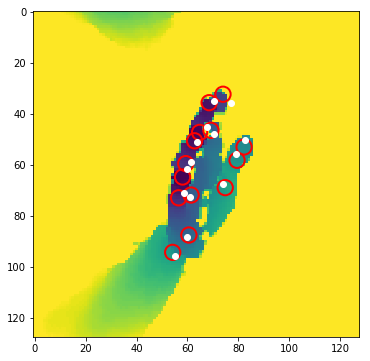

In [29]:
from matplotlib.patches import Circle
demo_image = dataset['image/test'][88]
demo_label = dataset['label/test'][88]
predictions = cur_model.predict(test_images, 64)
pred_label = predictions[88]
del predictions

plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.imshow(demo_image.squeeze())
for xx,yy in zip(demo_label[::3],demo_label[1::3]):
    circ = Circle((xx,yy),3,facecolor='none',linewidth=2,edgecolor='r')
    ax.add_patch(circ)
plt.plot(pred_label[::3], pred_label[1::3], 'wo')

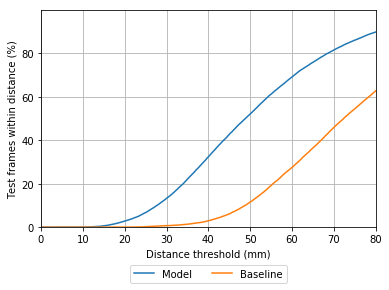

In [8]:
plt.figure()
plt.xlabel('Distance threshold (mm)')
plt.ylabel('Test frames within distance (%)')
plt.xlim([0., 80.])
plt.ylim([0., 100.])
plt.yticks(np.arange(0, 100, 20))
plt.grid()
predictions = cur_model.predict(test_images, 64)
error = threshold(\
                  uvd_to_xyz(denormalize(test_labels[:].reshape(-1, 14, 3), test_centers[:])),\
                  uvd_to_xyz(denormalize(predictions.reshape(-1, 14, 3), test_centers[:])),\
                  np.linspace(0, 80, 1000)\
                 )
del predictions
plt.plot(np.linspace(0, 80, 1000), error * 100,label='Model')
predictions = benchmark_model.predict(test_images, 64)
error = threshold(\
                  uvd_to_xyz(denormalize(test_labels[:].reshape(-1, 14, 3), test_centers[:])),\
                  uvd_to_xyz(denormalize(predictions.reshape(-1, 14, 3), test_centers[:])),\
                  np.linspace(0, 80, 1000)\
                 )
del predictions
plt.plot(np.linspace(0, 80, 1000), error * 100,label='Baseline')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)